In [3]:
# train model to do regression

In [4]:
# generate data
# 1. fit data w/ curve
# 2. fit data w/ mlp

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [6]:
x = np.random.uniform(size=1000)
m = 5.92
b = -3.16
noise = np.random.normal(0, 3, size=1000)

In [7]:
y = m * x + b + noise

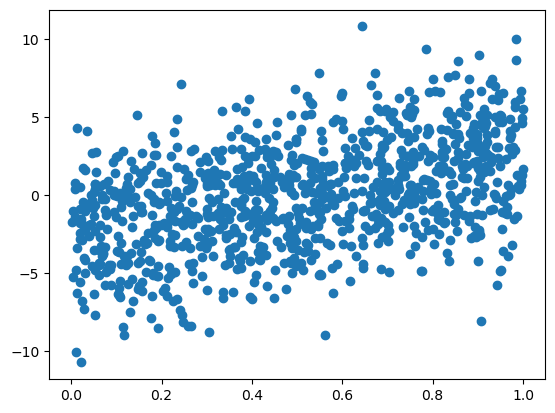

In [8]:
plt.scatter(x, y)

In [9]:
# linear regression: 
coeff = np.polyfit(x, y, 1)

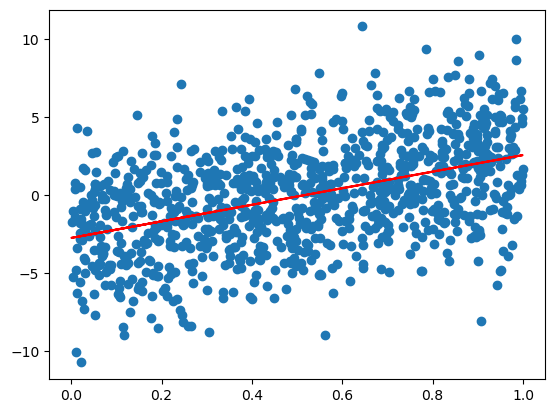

In [10]:
y_hat = coeff[0]*x + coeff[1]
plt.figure()
plt.scatter(x, y)
plt.plot(x, y_hat, color='red')

In [11]:
print(coeff, m, b)

[ 5.30354391 -2.75394653] 5.92 -3.16


In [12]:
# solve linear regression formula instead

In [13]:
# design mtx: y_hat = [x, 1]beta + eps
# add col of 1s to x
# beta = (x^T*x)^-1 * x^T*y
xs = np.reshape(x, (len(x), 1))
xs = np.hstack((xs, np.ones((len(x), 1))))

In [14]:
beta = np.linalg.inv(xs.T @ xs) @ (xs.T @ y)

In [15]:
y_hat_2 = xs @ beta

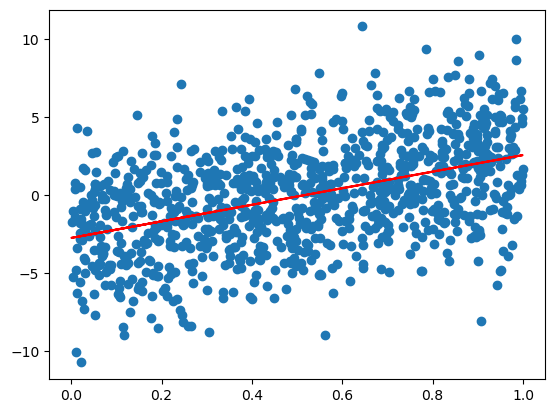

In [16]:
plt.figure()
plt.scatter(x, y)
plt.plot(x, y_hat_2, color='red')

In [17]:
print(beta, coeff, m, b)

[ 5.30354391 -2.75394653] [ 5.30354391 -2.75394653] 5.92 -3.16


In [18]:
# train mlp to do linreg
class MLP(nn.Module):
    def __init__(self, x_dim, h_dim):
        super().__init__()
        self.l1 = nn.Linear(x_dim, h_dim)
        self.l2 = nn.Linear(h_dim, x_dim)
        
    def forward(self, x):
        return self.l2(nn.functional.relu(self.l1(x)))

In [19]:
model = MLP(1, 10) #1 dim regression with 1000 training datapts, expand to hidden dim 10

In [20]:
# make torch dataset and dataloader for the data
class MyData(Dataset):
    def __init__(self, x, y):
        self.data = torch.from_numpy(x).unsqueeze(1).to(dtype=torch.float32)
        self.labels = torch.from_numpy(y).unsqueeze(1).to(dtype=torch.float32)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        data_pt = self.data[idx]
        label = self.labels[idx]
        return data_pt, label

In [27]:
# training loop
lr = 3e-4
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 1000

training_data = MyData(x[:900], y[:900])
test_data = MyData(x[900:], y[900:])
train_dl = DataLoader(training_data, batch_size=50, shuffle=True)
test_dl = DataLoader(test_data, batch_size=50, shuffle=False)

In [28]:
losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    model.train()
    for data, labels in train_dl:
        optimizer.zero_grad()
        y_hat = model(data)
        loss = criterion(y_hat, labels)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for data, labels in test_dl:
            # eval w test
            y_hat = model(data)
            test_loss += criterion(y_hat, labels)
        test_losses.append(test_loss.item() / len(test_dl))

  0%|          | 0/1000 [00:00<?, ?it/s]

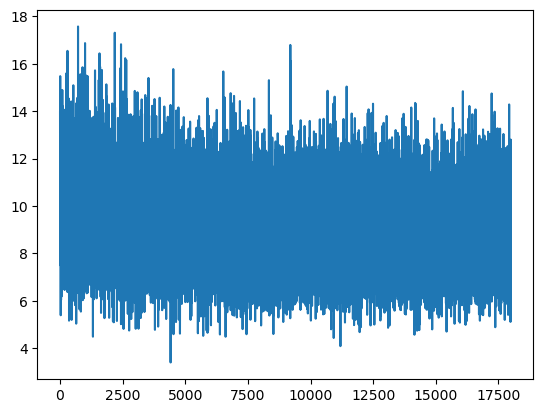

In [29]:
plt.plot(losses)

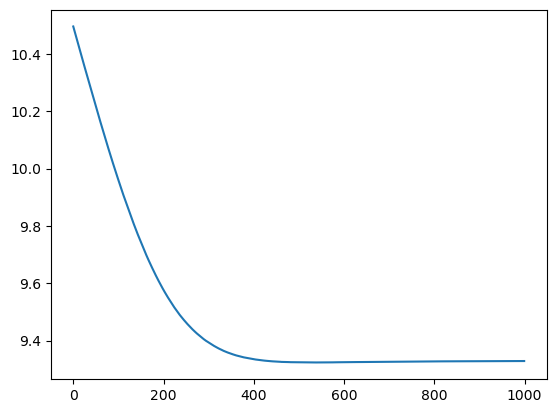

In [30]:
plt.plot(test_losses)

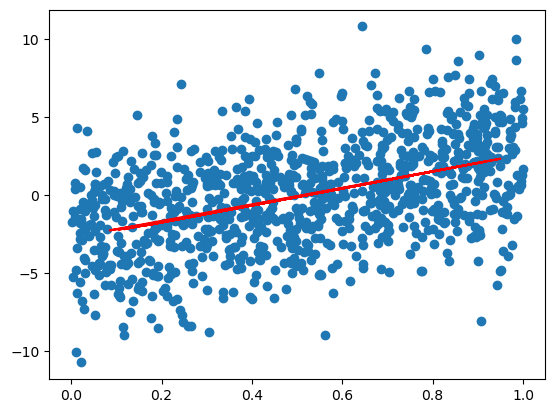

In [31]:
plt.scatter(x, y)
plt.plot(data, y_hat, color='red')

In [32]:
# get coeffs
# y = mx + b
# A = -m, 1
# B = b
# C = x, y
# solve for m and b instead
# B = y
# A = x, 1
# C = m, b
# C = solve(A, B)
A = torch.concat((data, torch.ones(data.shape)), dim=1)

coeff_mlp = np.linalg.lstsq(A.numpy(), y_hat.numpy())[0]

/var/folders/rm/_zhy3w7d0kq6nchczl8yk4yr0000gn/T/ipykernel_57410/2165221200.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff_mlp = np.linalg.lstsq(A.numpy(), y_hat.numpy())[0]


In [33]:
coeff_mlp

array([[ 5.414329 ],
       [-2.8334448]], dtype=float32)

In [36]:
print('mlp: ', coeff_mlp[0], coeff_mlp[1], 'np', beta, 'analytic', coeff, 'true', m, b)

mlp:  [5.414329] [-2.8334448] np [ 5.30354391 -2.75394653] analytic [ 5.30354391 -2.75394653] true 5.92 -3.16
